## Basic requirement
American-style calls and puts
1. CRR
2. BAW
3. LSMC(replace the OLS regression)


Inputs: $S_0$, $K$, $r$, $q$, $\sigma$, $T$, number of simulations, number of repetitions, $n$. Outputs:
Option values for all methods and 95% confidence interval for least-squares Monte Carlo simulation.

Note: 95% confidence interval = [mean of 20 repetitions − 2×(s.d. of 20 repetitions),
mean of 20 repetitions + 2×(s.d. of 20 repetitions)]

In [39]:
# Utils
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

def call(ST,K):
    return np.maximum(ST-K, 0)

def put(ST,K):
    return np.maximum(K-ST, 0)

def BS(S, K, T, r, div, sigma, option):
    d1 = (np.log(S/K) + (r-div+0.5*sigma**2)*T)/(sigma*T**0.5)
    d2 = d1 - (sigma*T**0.5)
    if option == 'call':
        return S*np.exp(-div*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    elif option == 'put':
        return -S*np.exp(-div*T)*norm.cdf(-d1) + K*np.exp(-r*T)*norm.cdf(-d2)

## CRR

In [40]:
def binomial_tree(S, K, T, r, div, sigma, N, method, option, Astyle=None):
    dt = T/N # time increament
    df = np.exp(-r*dt) # discount factor

    payoff = {'call': call, 'put': put}[option]

    if method == 'CRR':
        u = np.exp(sigma*np.sqrt(dt))
        d = 1/u
        q = (np.exp((r-div)*dt)-d) / (u-d)
    elif method == 'JR':
        u = np.exp((r-div-0.5*sigma**2)*dt + sigma*dt**0.5)
        d = np.exp((r-div-0.5*sigma**2)*dt - sigma*dt**0.5)
        q = 0.5

    stock_path = np.zeros((N+1, N+1))
    stock_path[0,0] = S
    for i in range(1, N+1):
        for j in range(i+1):
            stock_path[i,j] = S * u**(i-j) * d**j

    option_value = np.maximum(payoff(stock_path[N], K), 0)
    for i in range(N, 0, -1):
        for j in range(i):
            option_value[j] = (q * option_value[j] + (1-q) * option_value[j+1]) * df
            if Astyle == True:
                option_value[j] = max(option_value[j], payoff(stock_path[i-1, j], K))
    return option_value[0]

CRR=9.764307675566378, JR=9.808156874880577, BS=9.788002127460274
CRR=-0.24%, JR=0.21%
Note: BS are European options
CRR=9.223007917661175, JR=9.264655020195468, BS=9.192484674238571
CRR=0.33%, JR=0.79%
Note: BS are European options


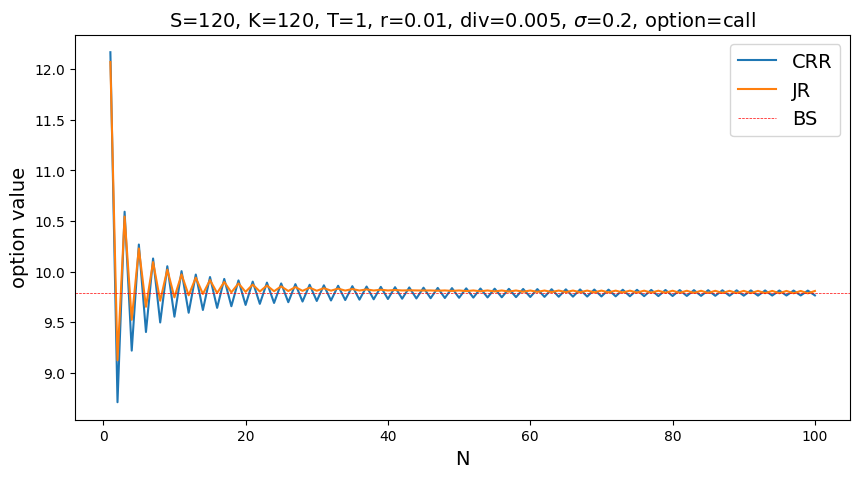

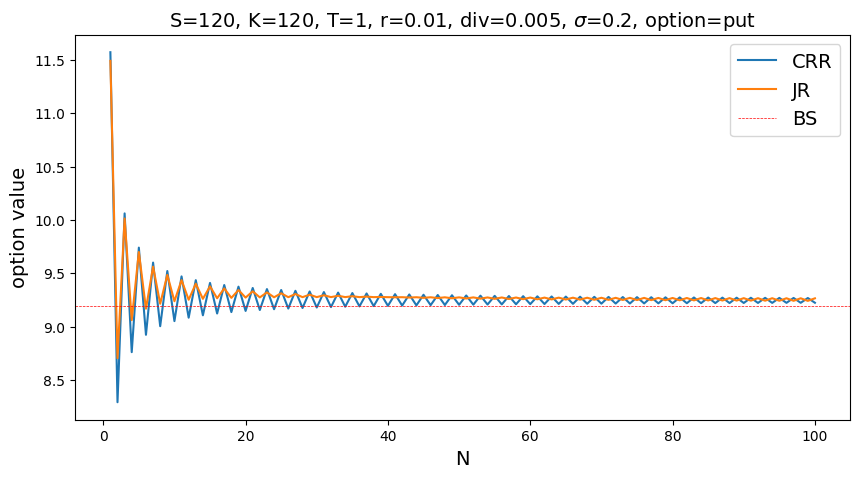

In [112]:
# (A)call
S = 120
K = 120
T = 1
r = 0.01
div = 0.005
sigma = 0.2
option = 'call'
N = np.arange(1, 101)
crr_res = []
jr_res = []
for n in N:
    crr_res.append(binomial_tree(S, K, T, r, div, sigma, n, 'CRR', option, True))
    jr_res.append(binomial_tree(S, K, T, r, div, sigma, n, 'JR', option, True))

plt.figure(figsize=(10,5))
plt.plot(N, crr_res, label='CRR')
plt.plot(N, jr_res, label='JR')
plt.title(f'S={S}, K={K}, T={T}, r={r}, div={div}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
bs_value = BS(S, K, T, r, div, sigma, option)  
plt.axhline(y=bs_value, color='r', linestyle='--', label=f'BS', linewidth=0.5)  
plt.legend(fontsize=14)
print(f'CRR={crr_res[-1]}, JR={jr_res[-1]}, BS={bs_value}')
crr_error_percentage = (crr_res[-1] - bs_value) / bs_value * 100
jr_error_percentage = (jr_res[-1] - bs_value) / bs_value * 100
print(f'CRR={crr_error_percentage:.2f}%, JR={jr_error_percentage:.2f}%')
print(f'Note: BS are European options')


# (A)put
S = 120
K = 120
T = 1
r = 0.01
div = 0.005
sigma = 0.2
option = 'put'
N = np.arange(1, 101)
crr_res = []
jr_res = []
for n in N:
    crr_res.append(binomial_tree(S, K, T, r, div, sigma, n, 'CRR', option, True))
    jr_res.append(binomial_tree(S, K, T, r, div, sigma, n, 'JR', option, True))

plt.figure(figsize=(10,5))
plt.plot(N, crr_res, label='CRR')
plt.plot(N, jr_res, label='JR')
plt.title(f'S={S}, K={K}, T={T}, r={r}, div={div}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
bs_value = BS(S, K, T, r, div, sigma, option)  
plt.axhline(y=bs_value, color='r', linestyle='--', label=f'BS', linewidth=0.5) 
plt.legend(fontsize=14)
print(f'CRR={crr_res[-1]}, JR={jr_res[-1]}, BS={bs_value}')
crr_error_percentage = (crr_res[-1] - bs_value) / bs_value * 100
jr_error_percentage = (jr_res[-1] - bs_value) / bs_value * 100
print(f'CRR={crr_error_percentage:.2f}%, JR={jr_error_percentage:.2f}%')
print(f'Note: BS are European options')

### CRR討論：
1. 有無股利的差異（買權美式與歐式相同）
2. 美式賣權恆比歐式賣權(BS)貴

## BAW

## Newton‘s Method

In [54]:
def _Kc(X, t, r, b, Sigma, option):
    _ITERATION_MAX_ERROR = 0.00001
    if option == 'call': 
        N = 2 * b / Sigma**2
        M = 2 * r / Sigma**2
        q2u = (-1 * (N - 1) + ((N - 1)**2 + 4 * M)**0.5) / 2  # p27.
        su = X / (1 - 1 / q2u)                                # p27.
        h2 = -1 * (b * t + 2 * Sigma * np.sqrt(t)) * X / (su - X)  # p31.
        Si = X + (su - X) * (1 - np.exp(h2))                       # p31.

        K = (1 - np.exp(-1 * r * t))
        d1 = (np.log(Si/X) + (b + Sigma**2 / 2) * t)/(Sigma * np.sqrt(t))
        q2 = (-1 * (N - 1) + ((N - 1)**2 + 4 * M / K)**0.5) / 2  # p16.
        LHS = Si - X
        # BS(S, K, T, r, div, sigma, option)
        RHS = BS(Si, X, t, r, r-b, Sigma, option) + (1 - np.exp((b - r) * t) * stats.norm.cdf(d1,0.0,1.0)) * Si / q2  # p23.
        bi = np.exp((b - r) * t) * stats.norm.cdf(d1,0.0,1.0) * (1 - 1 / q2) + (1 - np.exp((b - r) * t) * stats.norm.pdf(d1,0.0,1.0) / (Sigma * np.sqrt(t))) / q2  # p25. 

        E = _ITERATION_MAX_ERROR
        print(f'=======Call======')
        print(f'seed value誤差{(LHS - RHS)/X}')
        while np.abs(LHS - RHS) / X > E:        # p26.
            Si = (X + RHS - bi * Si) / (1 - bi) # p25.
            d1 = (np.log(Si / X) + (b + Sigma**2 / 2) * t) / (Sigma * np.sqrt(t))
            LHS = Si - X
            RHS = BS(Si, X, t, r, r-b, Sigma, option) + (1 - np.exp((b - r) * t) * stats.norm.cdf(d1,0.0,1.0)) * Si / q2
            bi = np.exp((b - r) * t) * stats.norm.cdf(d1,0.0,1.0) * (1 - 1 / q2) + (1 - np.exp((b - r) * t) * stats.norm.cdf(d1,0.0,1.0) / (Sigma * np.sqrt(t))) / q2
        
        return Si
    
    elif option == 'put':
        N = 2 * b / Sigma**2
        M = 2 * r / Sigma**2
        q1u = (-1 * (N - 1) - ((N - 1)**2 + 4 * M)**0.5) / 2  # f(32)
        su = X / (1 - 1 / q1u)                                # f(32).
        h1 =  (b * t - 2 * Sigma * np.sqrt(t)) * X / (X - su)  # f(33).
        Si = su + (X - su) * np.exp(h1)                     # f(33).

        K = (1 - np.exp(-1 * r * t))
        d1 = (np.log(Si/X) + (b + Sigma**2 / 2) * t)/(Sigma * np.sqrt(t))
        q1 = (-(N - 1) - ((N - 1)**2 + 4 * M / K)**0.5)/ 2  
        LHS = X - Si
        # BS(S, K, T, r, div, sigma, option)
        RHS = BS(Si, X, t, r, r-b, Sigma, option) - (1 - np.exp((b - r) * t) * stats.norm.cdf(-d1,0.0,1.0)) * Si / q1  # f(24)
        b2i = np.exp((b - r) * t) * stats.norm.cdf(-d1,0.0,1.0) * (1 + 1 / q1) + (1 + Si + np.exp((b - r) * t) * stats.norm.pdf(d1,0.0,1.0) / (Sigma * np.sqrt(t))) / q1  # p25. 

        E = _ITERATION_MAX_ERROR
        print(f'=======Put=======')
        print(f'seed value誤差{(LHS - RHS)/X}')
        while np.abs(LHS - RHS) / X > E:        # p26.
            Si = (-X + RHS + b2i * Si) / (-1 + b2i) 
            d1 = (np.log(Si / X) + (b + Sigma**2 / 2) * t) / (Sigma * np.sqrt(t))
            LHS = X - Si
            RHS = BS(Si, X, t, r, r-b, Sigma, option) - (1 - np.exp((b - r) * t) * stats.norm.cdf(-d1,0.0,1.0)) * Si / q1
            b2i = np.exp((b - r) * t) * stats.norm.cdf(-d1,0.0,1.0) * (1 + 1 / q1) + (1 + Si + np.exp((b - r) * t) * stats.norm.pdf(d1,0.0,1.0) / (Sigma * np.sqrt(t))) / q1  # p25. 
        
        return Si

In [55]:
S = 120
X = 120  # K
t = 1  # 選擇權到期時間（年）
r = 0.01  
b = 0.005  # 常數（持有成本 b=r-q, 設q=0.005）
Sigma = 0.2  # 波動率

option = 'call'
S_star = _Kc(X, t, r, b, Sigma, option)

print("買權臨界股價 S* =", S_star)

option = 'put'
S_star = _Kc(X, t, r, b, Sigma, option)
print("賣權臨界股價 S* =", S_star)

=======Call======
seed value誤差-0.015502558951654363
買權臨界股價 S* = 276.20601135913154
=======Put=======
seed value誤差-0.0014448380563076549
賣權臨界股價 S* = 82.35592758113108


## 使用臨界股價求出美式選擇權近似解

In [113]:
def _approximateAmericanOption(S, X, t, r, b, Sigma, option):
    '''
    Barone-Adesi And Whaley
    '''
    if option == 'call':
        if b >= r:                               # 無股利發放
            return BS(S, X, t, r, r-b, Sigma, option)
        else:                                    # 有股利發放
            Sk = _Kc(X, t, r, b, Sigma, option)
            N = 2 * b / Sigma**2
            M = 2 * r / Sigma**2
            K = (1 - np.exp(-1 * r * t))
            d1 = (np.log(Sk / X) + (b + (Sigma**2) / 2) * t) / (Sigma * (t**0.5))
            q2 = (-1 * (N - 1) + ((N - 1)**2 + 4 * M / K)**0.5) / 2
            A2 = (Sk / q2) * (1 - np.exp((b - r) * t) * stats.norm.cdf(d1,0.0,1.0))  # P21.
            if S < Sk:
                return BS(S, X, t, r, r-b, Sigma, option) + A2 * (S / Sk)**q2  # 小於臨界股價 P21.
            else:
                return S - X          
    elif option == 'put':
        # 美式賣權有無股利都比歐式賣權來得大
        Sk = _Kc(X, t, r, b, Sigma, option)
        N = 2 * b / Sigma**2
        M = 2 * r / Sigma**2
        K = (1 - np.exp(-1 * r * t))
        d1 = (np.log(Sk / X) + (b + (Sigma**2) / 2) * t) / (Sigma * (t**0.5))
        q1 = (-(N - 1) - ((N - 1)**2 + 4 * M / K)**0.5) / 2
        # print(q1)
        A1 = -(Sk / q1) * (1 - np.exp((b - r) * t) * stats.norm.cdf(-d1,0.0,1.0))  # P21.
        if S > Sk:
            return BS(S, X, t, r, r-b, Sigma, option) + A1 * (S / Sk)**q1  # 大於臨界股價 P21.
        else:
            return X - S   
   

In [114]:
option = 'call'
Amcall_price = _approximateAmericanOption(S, X, t, r, b, Sigma, option)
print("美式買權價格 =", Amcall_price)

option = 'put'
Amput_price = _approximateAmericanOption(S, X, t, r, b, Sigma, option)
print("美式賣權價格 =", Amput_price)

=======Call======
seed value誤差-0.015502558951654363
美式買權價格 = 9.788365616957941
=======Put=======
seed value誤差-0.0014448380563076549
美式賣權價格 = 9.235596741592884


## BAW討論
1. put的臨界股價$S^{**}$推導

## LSMC

In [68]:
def stock_simu(S, T, r, div, sigma, N, M, seed):
    dt = T / N
    np.random.seed(seed)  
    paths = np.zeros((N + 1, M))
    paths[0] = S

    for t in range(1, N + 1):
        Z = np.random.standard_normal(int(M/2))
        Z = np.concatenate((Z, -Z))
        paths[t] = paths[t - 1] * np.exp((r - div - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

def least_squares_MC(S, K, T, r, div, sigma, M, N, order, option, seed):
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r*(T/N))
    stock_paths = stock_simu(S, T, r, div, sigma, N, M, seed)

    payoffs = payoff(stock_paths, K)

    exercise_values = np.zeros_like(payoffs)
    exercise_values[-1] = payoffs[-1]

    for t in range(N-1, 0, -1):
        in_the_money = payoffs[t]>=0
        reg = np.polyfit(stock_paths[t][in_the_money], exercise_values[t+1][in_the_money]*df, order)
        
        C = np.polyval(reg, stock_paths[t][in_the_money])
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
        payoffs[t][in_the_money],exercise_values[t+1][in_the_money] * df)
        exercise_values[t][~in_the_money] = payoffs[t+1][~in_the_money] * df
    return np.mean(exercise_values[1]*df), np.std(exercise_values[1]*df)/M**0.5

In [87]:
from sklearn.linear_model import Lasso

def least_squares_MC_with_LASSO(S, K, T, r, div, sigma, M, N, order, option, seed):
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r * (T / N))
    stock_paths = stock_simu(S, T, r, div, sigma, N, M, seed)

    payoffs = payoff(stock_paths, K)

    exercise_values = np.zeros_like(payoffs)
    exercise_values[-1] = payoffs[-1]

    for t in range(N - 1, 0, -1):
        in_the_money = payoffs[t] >= 0
        
        # 使用 LASSO 
        reg = Lasso(alpha=0.5)  
        reg.fit(stock_paths[t][in_the_money].reshape(-1, 1), exercise_values[t + 1][in_the_money] * df)
        C = reg.predict(stock_paths[t][in_the_money].reshape(-1, 1))
        
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
        payoffs[t][in_the_money],exercise_values[t + 1][in_the_money] * df)
        exercise_values[t][~in_the_money] = payoffs[t + 1][~in_the_money] * df
    return np.mean(exercise_values[1] * df), np.std(exercise_values[1] * df) / M**0.5


In [91]:
import statsmodels.api as sm

def least_squares_MC_with_WLS(S, K, T, r, div, sigma, M, N, order, option, seed):
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r*(T/N))
    stock_paths = stock_simu(S, T, r, div, sigma, N, M, seed)
    payoffs = payoff(stock_paths, K)
    exercise_values = np.zeros_like(payoffs)
    exercise_values[-1] = payoffs[-1]

    for t in range(N-1, 0, -1):
        in_the_money = payoffs[t] >= 0
        x = stock_paths[t][in_the_money]
        y = exercise_values[t+1][in_the_money] * df

        # WLS
        wls_model = sm.WLS(y, sm.add_constant(x), weights=1/x)  
        results = wls_model.fit()
        C = results.predict(sm.add_constant(x))
        
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
        payoffs[t][in_the_money],exercise_values[t+1][in_the_money] * df)
        exercise_values[t][~in_the_money] = payoffs[t+1][~in_the_money] * df

    return np.mean(exercise_values[1] * df), np.std(exercise_values[1] * df) / M**0.5


Pricing Value
-----------------
Monte Carlo mean: 9.060
Monte Carlo std: 0.032
Monte Carlo CI: [8.996, 9.124]


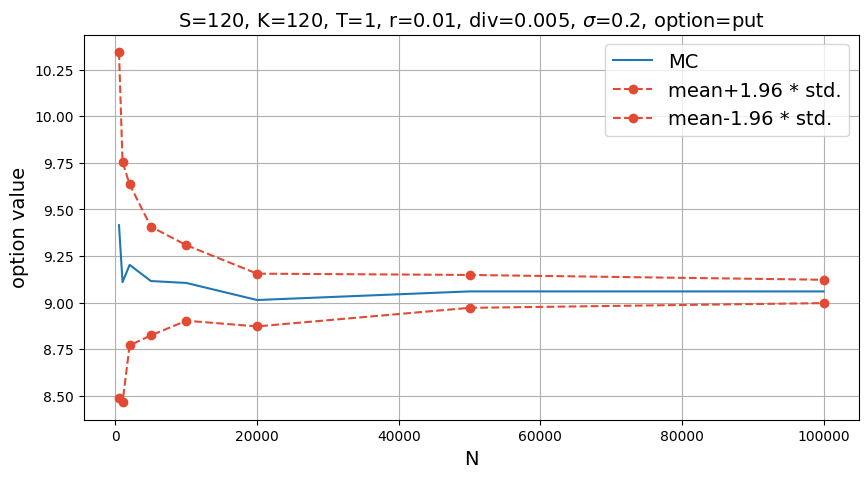

In [118]:
S = 120
K = 120
T = 1
r = 0.01
div = 0.005
sigma = 0.2
N = 100
option = 'put'
seed = 123
M = [500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC(S, K, T, r, div, sigma, n, N, 5, option, seed)
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')
print(f"Monte Carlo CI: [{mc_mean[-1]-2*mc_std[-1]:.3f}, {mc_mean[-1]+2*mc_std[-1]:.3f}]")

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='MC')
plt.plot(M, mc_mean+1.96*mc_std, label='mean+1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean-1.96*mc_std, label='mean-1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, div={div}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

## Extension works

In [192]:
from scipy import optimize
from scipy.stats import norm

def calculate_implied_volatility(option_price, S, K, r, T, option_type):
    def black_scholes(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'Call':
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) - option_price
        else:  # Put option
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1) - option_price
    
    return optimize.newton(black_scholes, 0.5, tol=1e-10, maxiter=1000)  # 牛頓法

In [170]:
# 台指期現價:17510
import pandas as pd
a = pd.read_csv('/Users/shawn/Github/M1/選擇權-評價與應用/Final_project/call.csv')
implied_volatilities = []
for index, row in a.iterrows():
    option_price = row['結算價']
    S = 17510
    K = row['履約價']
    r = 0.016  # 台灣銀行一年定存利率
    T = row['到期時間（年）']
    implied_volatility = calculate_implied_volatility(option_price, S, K, r, T, 'Call')
    implied_volatilities.append(implied_volatility)
    # print(implied_volatilities)

a['implied_vola'] = implied_volatilities  
a.head()

,契約,到期月份,履約價,買賣權,結算價,到期時間（年）,implied_vola
0,TXO,202401W2,15700,Call,1830.0,0.019231,0.442633
1,TXO,202401W2,15800,Call,1730.0,0.019231,0.421160
2,TXO,202401W2,15900,Call,1630.0,0.019231,0.399681
3,TXO,202401W2,16000,Call,1530.0,0.019231,0.378185
4,TXO,202401W2,16100,Call,1430.0,0.019231,0.356656


In [171]:
len(implied_volatilities)

252

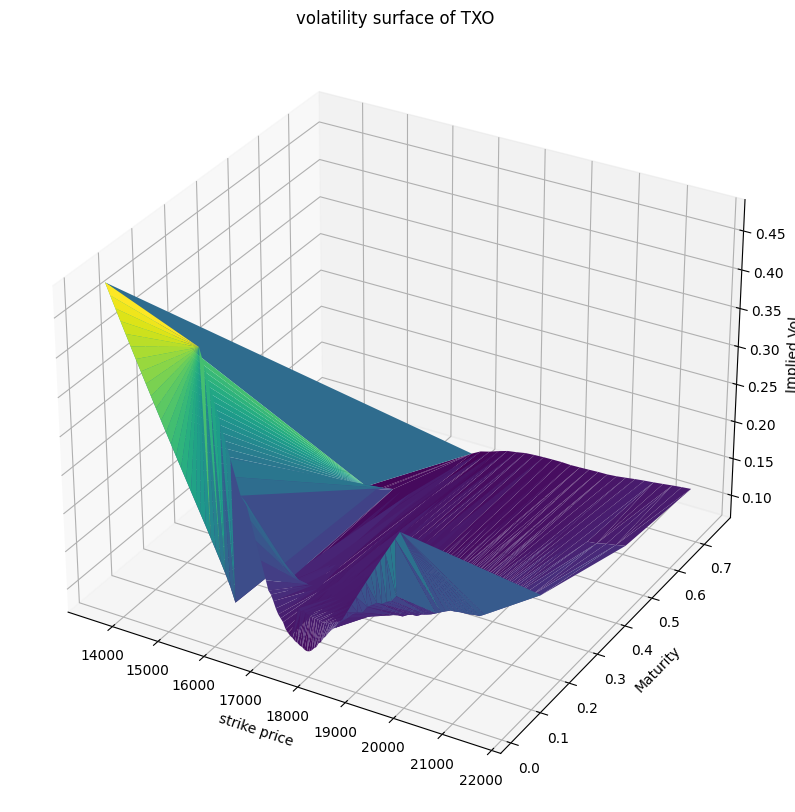

In [191]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


a['履約價'] = pd.to_numeric(a['履約價'], errors='coerce')
a['implied_vola'] = pd.to_numeric(a['implied_vola'], errors='coerce')
a['到期時間（年）'] = pd.to_numeric(a['到期時間（年）'], errors='coerce')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x = a['履約價']
y = a['到期時間（年）']
z = a['implied_vola']

ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')

ax.set_xlabel('strike price')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Vol')

plt.title('volatility surface of TXO')

plt.show()